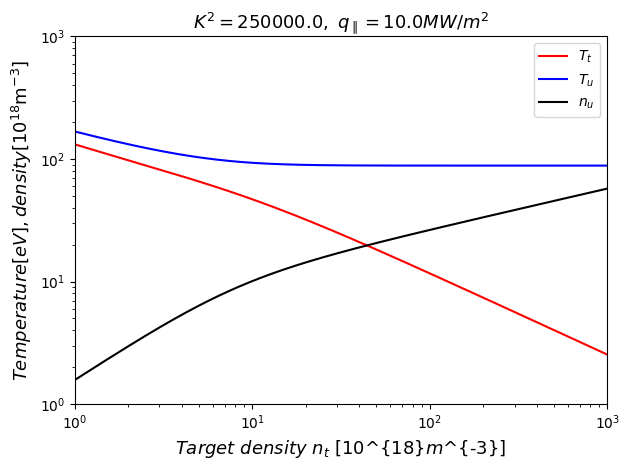

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

@nb.jit
def find_qt(nt, K2, gamma_hat, q):
    qt_init = q-1000.0 #arbitrary
    qt_guess = qt_init
    Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
    Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
    qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
    
    N = 1
    #print(qt_guess - qt_new, qt_new - q)
    while (np.abs(qt_guess - qt_new) > 1e-14) and (N < 1000):
        qt_guess = qt_new
        Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
        Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
        qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
        #print(qt_guess - qt_new, qt_new - q)
        N += 1
    
    return qt_new, Tt_guess, Tu_guess

@nb.jit
def get_results(nt, K2, gamma_hat, q):
    qt = np.zeros_like(nt)
    Tt = np.zeros_like(nt)
    Tu = np.zeros_like(nt)

    for i in range(0,len(nt)):
        qt[i], Tt[i], Tu[i] = find_qt(nt[i], K2, gamma_hat, q)

    nu = 2*nt*Tt/Tu

    return Tt, Tu, nu, qt

a = 2.0e3 # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]
K_sqr = 25e4

N = int(1e4)

nt = np.logspace(0, 3, N)
qt = np.zeros((8, N))
Tt = np.zeros((8, N))
Tu = np.zeros((8, N))
nu = np.zeros((8, N))

Tt, Tu, nu, qt = get_results(nt, K_sqr, gamma_hat, heat_flux)
Tt_2pt, Tu_2pt, nu_2pt, qt_2pt = get_results(nt, 0, gamma_hat, heat_flux)


# x-axis = (1)nt (2)Tt (3)Tu
plot = 1
if plot == 1:
    plt.loglog(nt, Tt, color = 'r', label = f'$T_t$')
    plt.loglog(nt, Tu, color = 'b', label = f'$T_u$')
    plt.loglog(nt, nu, color = 'black', label = f'$n_u$')
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Target\ density\ n_t\ [$10^{18}$m$^{-3}$]$', fontsize = 13)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()
elif plot == 2:
    plt.loglog(Tt, nt, color = 'g', label = f'$n_t$')
    plt.loglog(Tt, Tu, color = 'b', label = f'$T_u$')
    plt.loglog(Tt, nu, color = 'black', label = f'$n_u$')
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Target\ temperature\ T_t\ [eV]$', fontsize = 13)
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()
elif plot == 3:
    plt.loglog(Tu, nt, color = 'r', label = f'$n_t$')
    plt.loglog(Tu, Tt, color = 'b', label = f'$T_t$')
    plt.loglog(Tu, nu, color = 'black', label = f'$n_u$')
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Upstream\ temperature\ T_u\ [eV]$', fontsize = 13)
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Second solver: f mapping and solve_ivp

In [3]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ode(z, y):
    f = y[0]  # y1 = f
    df_dz = y[1]  # y2 = df/dz
    dy2_dz = -K_sqr * (7 / 2 * f) ** (-3 / 7)
    return [df_dz, dy2_dz]

# 射击法的边界条件

def boundary_conditions(guess):
    # 初始条件 [f(0), df/dz(0)]
    y0 = [f_Z, guess]
    sol = solve_ivp(ode, [0, Lz], y0, t_eval=z_arr, method='RK45', rtol=1e-8)
    
    # 检查边界条件在 z = Lz 处是否满足
    f_Lz = sol.y[0][-1]
    return f_Lz - Tt[index]

# 使用初值法迭代以找到合适的斜率
from scipy.optimize import root

z_arr = np.linspace(0, Lz, N)

index = -1
f_Z = 2 / 7 * Tt[index] ** (7 / 2)  # 定义 f(Z)
df0_dz = heat_flux / (-a)  # 定义 df(Z)/dz
print(Tt[index])

# 使用 root 方法找到初始斜率使得边界条件满足
initial_guess = df0_dz
solution_guess = root(boundary_conditions, initial_guess)

if solution_guess.success:
    final_slope = solution_guess.x[0]
    # 使用找到的斜率解 ODE
    y0 = [f_Z, final_slope]
    sol = solve_ivp(ode, [0, Lz], y0, t_eval=z_arr, method='RK45', rtol=1e-8)
    
    # 将解还原到温度的形式
    T_u = (7 / 2 * sol.y[0, 0]) ** (2 / 7)
    T_t = (7 / 2 * sol.y[0, -1]) ** (2 / 7)

    # 打印结果
    print("ODE Solution using Shooting Method:")
    print("T_u = ", T_u, " T_t = ", T_t)
    print("Check Dirichlet BC (f(L)): Error = ", abs(sol.y[0, -1] - Tt[index]))
    print('Check Neumann BC (f_prime(0)): Error = ', abs(sol.y[1][0] - df0_dz))
    
    # 作图
    plt.plot(np.linspace(0, Lz, sol.y[0].size), (7 / 2 * sol.y[0]) ** (2 / 7), label="Temperature Profile")
    plt.xlabel("z")
    plt.ylabel("Temperature (T)")
    plt.title("Temperature Profile using Shooting Method")
    plt.legend()
    plt.show()
else:
    print("Shooting method did not converge")


2.533864019073476
Shooting method did not converge


/home/penguindrum/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)
/tmp/ipykernel_83032/2930755820.py:9: RuntimeWarning: invalid value encountered in double_scalars
  dy2_dz = -K_sqr * (7 / 2 * f) ** (-3 / 7)
